In [1]:
import os
import sys
sys.path.append('../sdbm/code')
sys.path.append('../DeepView/deepview')
sys.path.append('../dbm_evaluation')
# import make blobs
from sklearn.datasets import make_blobs
# import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import torch as T
import torch.linalg as LA

from ssnp import SSNP
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
# import skdim

from map_evaluation import P_wrapper, MapBuilder
from ssnp import SSNP

sys.path.append('../GAN_inverse_projection')
# from utils import GANinv, CGANinv
from umap import UMAP
from LID import ID_finder_T, get_data_LID, get_eigen_general , ID_finder_np

from lamp import Pinv_ilamp
from rbf_inv import RBFinv

import os

2024-07-10 15:05:34.408493: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 15:05:34.497339: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-10 15:05:34.518382: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-10 15:05:35.139699: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:

class Simple_P_wrapper:
    def __init__(self, P, Pinv, bottleneck_dim=2):
        self.P = P
        self.Pinv = Pinv
        self.bottleneck_dim = bottleneck_dim
    def __call__(self, x):
        return self.P(x)
    def transform(self, x):
        return self.P.transform(x)
    def inverse_transform(self, x):
        return self.Pinv.transform(x)

    def fit(self, x, y=None, clf=None):
        # self.P.fit(x)
        self.X2d = self.P.fit_transform(x)
        self.Pinv.fit(self.X2d, x )
        return self

In [3]:
data_dir = '../sdbm/data'
data_dirs = [
    # 'blobs_dim3_n5000_y5',
    # 'blobs_dim10_n5000_y5',
    # 'blobs_dim30_n5000_y5',
    # 'blobs_dim100_n5000_y5',
    # 'blobs_dim300_n5000_y5',

    # 'blobs_dim3_n5000_y2',
    # 'blobs_dim10_n5000_y2',
    # 'blobs_dim30_n5000_y2',
    # 'blobs_dim100_n5000_y2',
    # 'blobs_dim300_n5000_y2',

    # 'blobs_dim3_n5000_y3',
    # 'blobs_dim10_n5000_y3',
    # 'blobs_dim30_n5000_y3',
    # 'blobs_dim100_n5000_y3',
    # 'blobs_dim300_n5000_y3',
    # 'blobs_dim3_n500_y10',
    # 'blobs_dim3_n5000_y10',
    # 'blobs_dim10_n5000_y10',

    'blobs_dim30_n5000_y10',
    # 'blobs_dim60_n5000_y10',
    # 'blobs_dim90_n5000_y10',

    # # 'blobs_dim300_n1500_y10',

    # 'har', 
    'mnist', 
    # 'fashionmnist', 
    # 'reuters', 
    ]

datasets_real = {}

for d in data_dirs:
    dataset_name = d
    if not 'blob' in d:
        X = np.load(os.path.join(data_dir, d,  'X.npy'))
        y = np.load(os.path.join(data_dir, d, 'y.npy'))

    #blobs
    else:
        dim = int(d.split('_')[1][3:])
        print(dim)
        n_class = int(d.split('_')[3][1:])
        X, y = make_blobs(n_samples=6000, n_features=dim, centers=n_class, cluster_std=1, random_state=0)
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X).astype(np.float32)
    ######
    n_samples = X.shape[0]
    n_classes = len(np.unique(y))

    if 'blob' in d:
        train_size = dim = int(d.split('_')[2][1:])
    else:
        train_size = min(int(n_samples*0.9), 5000)
    test_size = 5000 # inverse
    
    dataset =\
        train_test_split(X, y, train_size=train_size, random_state=420, stratify=y)
    datasets_real[dataset_name] = dataset
    # print(X.shape)

    ## clip dataset[1] and dataset[3] to test_size if they are larger
    if dataset[1].shape[0] > test_size:
        dataset[1] = dataset[1][:test_size]
        dataset[3] = dataset[3][:test_size]


projectors = {
            # 'SDBM' : P_wrapper(ssnp=1),
            # 'DBM': P_wrapper(NNinv_Torch=1, ),
            # 'DeepView': P_wrapper(deepview=1),
            # 'DBM_orig_keras': P_wrapper(NNinv_Keras=1),
            'UMAP+iLAMP': Simple_P_wrapper(UMAP(random_state=42), Pinv_ilamp()),
            'UMAP+RBF': Simple_P_wrapper(UMAP(random_state=42), RBFinv()),
            # 'SSNP_3' : SSNP(patience=5, opt='adam', bottleneck_activation='linear', verbose=0, bottleneck_dim=3),
            # 'SSNP_10' : SSNP(patience=5, opt='adam', bottleneck_activation='linear', verbose=0, bottleneck_dim=10),
            # 'SSNP_30' : SSNP(patience=5, opt='adam', bottleneck_activation='linear', verbose=0, bottleneck_dim=30),
            
            # 'DBM_2' : P_wrapper(NNinv_Torch=1, bottleneck_dim=2),
            # 'DBM_5' : P_wrapper(NNinv_Torch=1, bottleneck_dim=5),
            # 'DBM_10' : P_wrapper(NNinv_Torch=1, bottleneck_dim=10),
            # 'DBM_15' : P_wrapper(NNinv_Torch=1, bottleneck_dim=15),
            # 'DBM_20' : P_wrapper(NNinv_Torch=1, bottleneck_dim=20),

            # 'DBM_3_PCA' : P_wrapper(NNinv_Torch=1, bottleneck_dim=3, P='PCA'),
            # 'DBM_10_PCA' : P_wrapper(NNinv_Torch=1, bottleneck_dim=10, P='PCA'),
            # 'DBM_30_PCA' : P_wrapper(NNinv_Torch=1, bottleneck_dim=30, P='PCA'),

            # 'DBM_3_tSNE' : P_wrapper(NNinv_Torch=1, bottleneck_dim=3, P='tSNE'),
            # 'DBM_10_tSNE' : P_wrapper(NNinv_Torch=1, bottleneck_dim=10, P='tSNE'),
            # 'DBM_30_tSNE' : P_wrapper(NNinv_Torch=1, bottleneck_dim=30, P='tSNE'),
            }

30


### MNSIT

In [4]:
mnist = datasets_real['mnist']
x_mnist = mnist[0]
y_mnist = mnist[2]

clf_mnist = LogisticRegression(max_iter=1000)
clf_mnist.fit(x_mnist, y_mnist)


LogisticRegression(max_iter=1000)

In [5]:
ilmap_mnist = projectors['UMAP+iLAMP']
ilmap_mnist.fit(x_mnist, y_mnist)


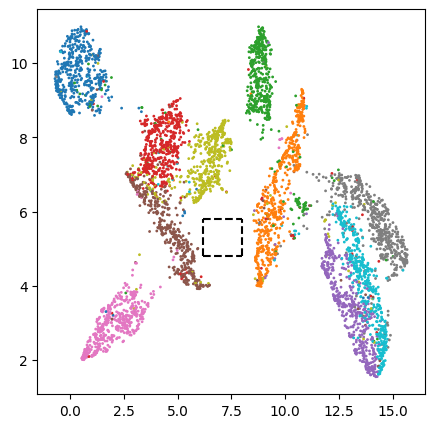

In [76]:
mnist_2d = ilmap_mnist.P.embedding_
cmap = 'tab10'
# blob_c = cm.tab10(blob30_y/9)
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(mnist_2d[:,0], mnist_2d[:,1], c=y_mnist, cmap=cmap, s=1)

## rect 1
x_min, x_max = [6.2, 8]
y_min, y_max = [4.8, 5.8]

## rect 2
# x_min, x_max = [8., 9.]
# y_min, y_max = [7.1, 7.7]

# ## rect 3
# x_min, x_max = [5.8, 7.5]
# y_min, y_max = [9.4, 10.4]

GRID = 50

# plot the rectangular
plt.plot([x_min, x_min], [y_min, y_max], 'k--')
plt.plot([x_max, x_max], [y_min, y_max], 'k--')
plt.plot([x_min, x_max], [y_min, y_min], 'k--')
plt.plot([x_min, x_max], [y_max, y_max], 'k--')


xx, yy = np.meshgrid(np.linspace(x_min, x_max, GRID), np.linspace(y_min, y_max, GRID))
XY_MNSIT = np.c_[xx.ravel(), yy.ravel()]

(250000,)


100%|██████████| 65/65 [00:00<00:00, 129761.90it/s]


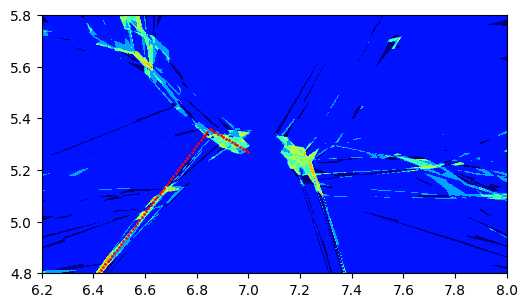

In [89]:
eigen_list_load = np.load('local/eigen_list.npy')
shape = (500, 500)
blob_box = (eigen_list_load >= (1-0.99)).sum(axis=1).reshape(shape)

### TV
# cumsum = T.cumsum(T.tensor(eigen_list), dim=1)
# blob_box = (cumsum < 0.85).sum(dim=1) + 1
# blob_box = blob_box.cpu().numpy().reshape(shape)


percent_list = np.sum(eigen_list_load[:, :2], axis=1)
print(percent_list.shape)
percent_list = percent_list.reshape(shape)
# flip the
blob_box = np.flip(blob_box, axis=0)
percent_list = np.flip(percent_list, axis=0)

fig, ax1 = plt.subplots(1, 1, figsize=(6,6))
vmin = np.min(blob_box)
vmax = np.max(blob_box)
cmap = plt.get_cmap('jet', vmax - vmin + 1)

###
# x_min, x_max, y_min, y_max = 0, 1, 0, 1
im1 = ax1.imshow(blob_box, cmap=cmap, extent=[x_min, x_max, y_min, y_max], vmin=vmin-0.5, vmax=vmax+0.5)

start = [6.42, 4.8]
end = [6.85, 5.36]
end2 = [7, 5.27]
n_points = 50
points1 = np.linspace(start, end, n_points)
points2 = np.linspace(end, end2, 15)
# ax1.scatter(points[:,0], points[:,1], c='r', s=1)
points = np.vstack([points1, points2])
ax1.scatter(points[:,0], points[:,1], c='r', s=1)


points_inv = ilmap_mnist.inverse_transform(points)
points_inv = points_inv.reshape(-1, 28, 28)

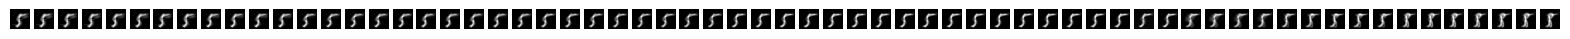

In [91]:
fig, axes = plt.subplots(1, len(points_inv), figsize=(20, 10))
for i, ax in enumerate(axes):
    ax.imshow(points_inv[i], cmap='gray')
    ax.axis('off')

100%|██████████| 50/50 [00:00<00:00, 115800.77it/s]


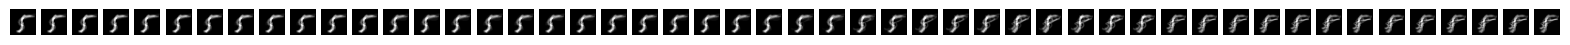

In [57]:
start = [6.3, 5]
end = [7, 5]
n_points = 50
points = np.linspace(start, end, n_points)
points_inv = ilmap_mnist.inverse_transform(points)
points_inv = points_inv.reshape(-1, 28, 28)
fig, ax = plt.subplots(1, n_points, figsize=(20, 20))
for i in range(n_points):
    ax[i].imshow(points_inv[i], cmap='gray')
    ax[i].axis('off')

In [51]:
MNSIT_inv = ilmap_mnist.inverse_transform(XY_MNSIT)


100%|██████████| 500/500 [00:00<00:00, 98726.67it/s]


In [52]:
GRID_smaple = 20
xx2, yy2 = np.meshgrid(np.linspace(x_min, x_max, GRID_smaple), np.linspace(y_min, y_max, GRID_smaple))
XY_MNSIT_sample = np.c_[xx2.ravel(), yy2.ravel()]
MNSIT_inv_sample = ilmap_mnist.inverse_transform(XY_MNSIT_sample)

100%|██████████| 400/400 [00:00<00:00, 105344.82it/s]


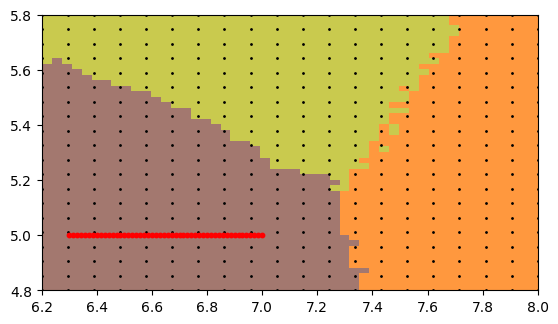

In [58]:
labels = clf_mnist.predict(MNSIT_inv)
labels = labels.reshape(xx.shape)
# labels = np.flip(labels, axis=0)
labels_color = cm.tab10(labels/9)
plt.imshow(labels_color, extent=(x_min, x_max, y_min, y_max), origin='lower', alpha=0.8)
# plt.xticks([])
# plt.yticks([])
aspect='equal'

plt.scatter(XY_MNSIT_sample[:,0], XY_MNSIT_sample[:,1], c='black', s=1)
plt.scatter(points[:,0], points[:,1], c='red', s=10)

# plt.savefig('local/UMAP_iLAMP_mnist1.png', dpi=300, bbox_inches='tight')
# plt.savefig('local/UMAP_iLAMP_mnist1.pdf', dpi=300, bbox_inches='tight')


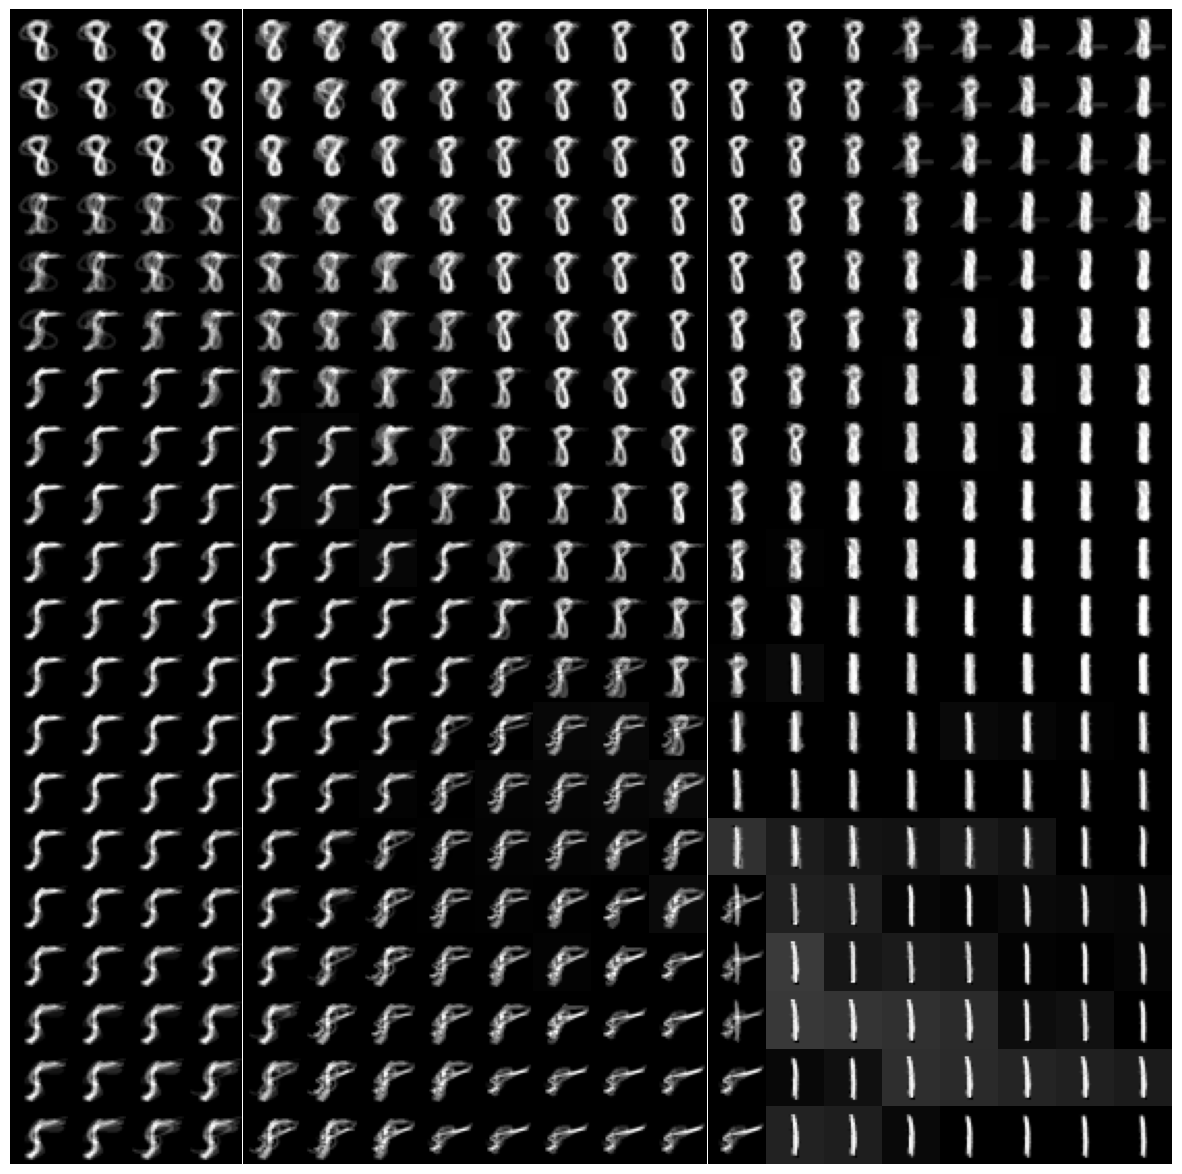

In [54]:
## plot the inverse
fig, axes = plt.subplots(GRID_smaple, GRID_smaple,figsize=(15, 15))
# wspace 0
fig.subplots_adjust(wspace=0, hspace=0)
MNSIT_inv_sample_flip = MNSIT_inv_sample.reshape(GRID_smaple, GRID_smaple, 28, 28)
# flip
MNSIT_inv_sample_flip = np.flip(MNSIT_inv_sample_flip, axis=0)

for i in range(GRID_smaple):
    for j in range(GRID_smaple):
        ax = axes[i, j]
        ax.imshow(MNSIT_inv_sample_flip[i,j], cmap='gray')
        ax.axis('off')
        


(48, 48)


([], [])

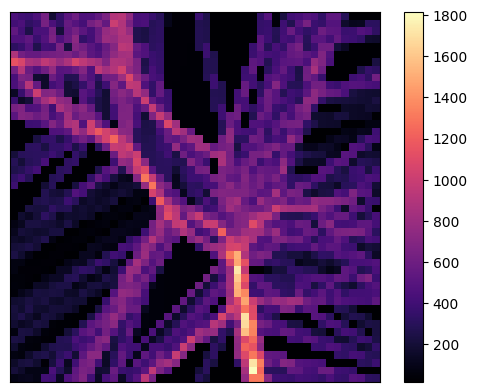

In [55]:
ndgrid_padding = MNSIT_inv.reshape(xx.shape[0], xx.shape[1], -1)
pixel_width, pixel_height = 1/498, 1/498
ndgrid_rec = ndgrid_padding[1:-1, 1:-1, :]

Dx = ndgrid_padding[2:, 1:-1] - ndgrid_padding[:-2, 1:-1]
Dy = ndgrid_padding[1:-1, 2:] - ndgrid_padding[1:-1, :-2]
Dx = Dx / (2 * pixel_width)
Dy = Dy / (2 * pixel_height)
# get the gradient norm
D = np.sqrt(np.sum(Dx**2, axis=2) + np.sum(Dy**2, axis=2)) 
D = np.flip(D, axis=0)
print(D.shape)
plt.imshow(D, cmap='magma')
cbar = plt.colorbar()

plt.xticks([])
plt.yticks([])

# save the figure   
# plt.savefig('local/gradient_mnist1.png', dpi=300, bbox_inches='tight')
# plt.savefig('local/gradient_mnist1.pdf', dpi=300, bbox_inches='tight')

In [28]:
eigen_list, lid_list = get_eigen_general(MNSIT_inv, GPU=True)


100%|██████████| 250000/250000 [1:06:35<00:00, 62.56it/s]


In [29]:
print(eigen_list.shape)
print(lid_list.shape)

(250000, 784)
(250000,)


In [59]:
## plot 
def plot_two(eigen_list, lid_list, title, shape=(500,500)):
    # blob_box = np.array(lid_list).reshape(shape)
    ## MV
    blob_box = (eigen_list >= (1-0.99)).sum(axis=1).reshape(shape)

    ### TV
    # cumsum = T.cumsum(T.tensor(eigen_list), dim=1)
    # blob_box = (cumsum < 0.85).sum(dim=1) + 1
    # blob_box = blob_box.cpu().numpy().reshape(shape)


    percent_list = np.sum(eigen_list[:, :2], axis=1)
    print(percent_list.shape)
    percent_list = percent_list.reshape(shape)
    # flip the
    blob_box = np.flip(blob_box, axis=0)
    percent_list = np.flip(percent_list, axis=0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
    vmin = np.min(blob_box)
    vmax = np.max(blob_box)
    cmap = plt.get_cmap('jet', vmax - vmin + 1)

    ###
    x_min, x_max, y_min, y_max = 0, 1, 0, 1
    im1 = ax1.imshow(blob_box, cmap=cmap, extent=[x_min, x_max, y_min, y_max], vmin=vmin-0.5, vmax=vmax+0.5)
    ax1.set_title(title)

    im2 = ax2.imshow(percent_list, cmap='cividis', extent=[x_min, x_max, y_min, y_max])
    ax2.set_title('percentile')
    # cbar 

    # no ticks
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ## equal axis

    ticks = np.arange(vmin, vmax + 1)
    # check if the ticks are too many, if so, reduce and make it intager
    while len(ticks) > 10:
        ticks = ticks[::2]
                        
    fig.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04, ticks=ticks)
    fig.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
    plt.show()
    return fig

fig = plot_two(eigen_list, lid_list, 'MNIST')
# fig.savefig('local/eigen_mnist1_MV099.png', dpi=300, bbox_inches='tight')
# fig.savefig('local/eigen_mnist1_MV099.pdf', dpi=300, bbox_inches='tight')

NameError: name 'eigen_list' is not defined

In [34]:
#save enigen and lid
if not os.path.exists('./local'):
    os.makedirs('./local')
    
np.save('./local/eigen_list_MNIST2.npy', eigen_list)


## Blob

In [4]:
blob30 = datasets_real['blobs_dim30_n5000_y10']
blob30_X = blob30[0]
blob30_y = blob30[2]

clf_blob = LogisticRegression(max_iter=1000, random_state=420)
clf_blob.fit(blob30_X, blob30_y)


LogisticRegression(max_iter=1000, random_state=420)

In [5]:
ilmap = projectors['UMAP+iLAMP']
rbf = projectors['UMAP+RBF']
ilmap.fit(blob30_X, blob30_y)
rbf.fit(blob30_X, blob30_y)


r:  (5000, 5000)
coefficients:  (5000, 30)


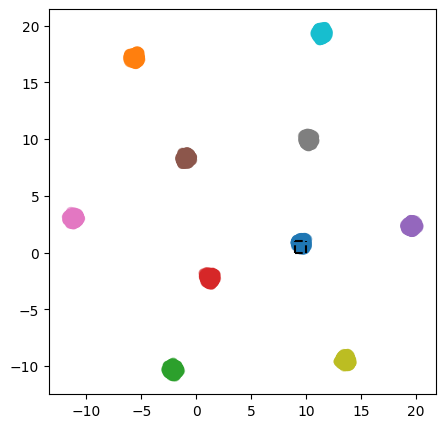

In [32]:
blob_2D = ilmap.P.embedding_
cmap = 'tab10'
# blob_c = cm.tab10(blob30_y/9)
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(blob_2D[:,0], blob_2D[:,1], marker='o', c=blob30_y, cmap=cmap, alpha=0.5)

x_min, x_max = [9, 10]
y_min, y_max = [-0., 1]

# plot the rectangular
plt.plot([x_min, x_min], [y_min, y_max], 'k--')
plt.plot([x_max, x_max], [y_min, y_max], 'k--')
plt.plot([x_min, x_max], [y_min, y_min], 'k--')
plt.plot([x_min, x_max], [y_max, y_max], 'k--')
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
XY_blob = np.c_[xx.ravel(), yy.ravel()]

In [33]:
blob_inv_ilamp = ilmap.inverse_transform(XY_blob)

print('computing LID')
eigen_list_ilamp_blob, lid_lsit_ilamp_blob = get_eigen_general(blob_inv_ilamp)

blob_inv_rbf = rbf.inverse_transform(XY_blob)
print('computing LID')
eigen_list_rbf_blob, lid_lsit_rbf_blob = get_eigen_general(blob_inv_rbf)

100%|██████████| 1992/1992 [00:00<00:00, 613485.10it/s]


computing LID


100%|██████████| 250000/250000 [25:03<00:00, 166.31it/s]


Phi_new:  (250000, 5000)
computing LID


100%|██████████| 250000/250000 [25:04<00:00, 166.13it/s]


(250000,)


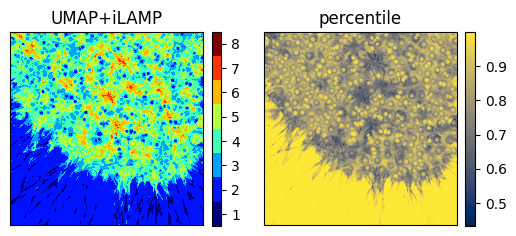

(250000,)


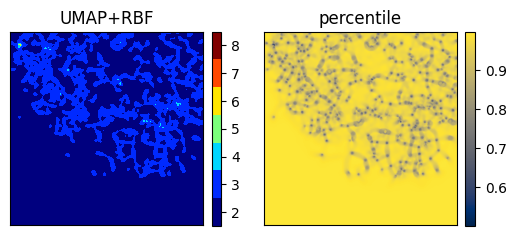

In [39]:

plot_two(eigen_list_ilamp_blob, lid_lsit_ilamp_blob, 'UMAP+iLAMP')
plot_two(eigen_list_rbf_blob, lid_lsit_rbf_blob, 'UMAP+RBF')


In [5]:
DV_blob = projectors['DeepView']
DV_blob.fit(blob30_X, blob30_y, clf=clf_blob)

100%|██████████| 5000/5000 [03:52<00:00, 21.47it/s] 


updating matrices
(0,) (5000, 5000)
discr 0.21222400665283203
(0,) (5000, 5000)
fitting mapper
transforming
fitting inverse
done
fitting time:  354.563969373703


354.563969373703

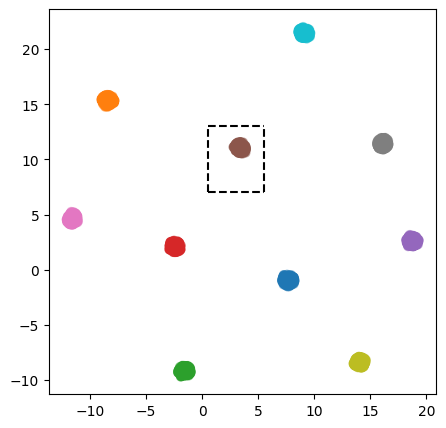

In [6]:
blob_2D = DV_blob.P.embedding_
cmap = 'tab10'
# blob_c = cm.tab10(blob30_y/9)
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(blob_2D[:,0], blob_2D[:,1], marker='o', c=blob30_y, cmap=cmap, alpha=0.5)

x_min, x_max = [0.5, 5.5]
y_min, y_max = [7, 13]

# plot the rectangular
plt.plot([x_min, x_min], [y_min, y_max], 'k--')
plt.plot([x_max, x_max], [y_min, y_max], 'k--')
plt.plot([x_min, x_max], [y_min, y_min], 'k--')
plt.plot([x_min, x_max], [y_max, y_max], 'k--')
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
XY_blob = np.c_[xx.ravel(), yy.ravel()]

In [92]:


print(XY_blob.shape)
# ax.plot(XY_blob[:,0], XY_blob[:,1], 'k.', alpha=0.1)
# fig

blob_inv = DV_blob.inverse_transform(XY_blob)

print('computing LID')
eigen_list, lid_lsit = get_eigen_general(blob_inv)


(250000, 2)


In [58]:
# save the data
# make dir
# if not os.path.exists('./local'):
#     os.makedirs('./local')
# np.save('./local/blob30_eigen_id.npy', blob_inv)

In [3]:
blob_local = np.load('./local/blob30_eigen_id.npy', allow_pickle=True)
lid_lsit = blob_local
eigen_list = blob_local[0]

blob_box = lid_lsit.reshape((500,500))
# flip the
# blob_box = np.flip(blob_box, axis=0)

# img = ax.imshow(blob_box, cmap='jet', alpha=0.9, extent=[x_min, x_max, y_min, y_max])
# blob_box_mean = np.mean(blob_box)
# ax.text(0.5, 12, f'LID={blob_box_mean:.2f}', fontsize=15, )
# # cbar
# cbar = fig.colorbar(img, ax=ax)
cnt = plt.contourf(xx, yy, blob_box, cmap='jet', alpha=0.9, levels=[0.5, 1.5, 2.5, 3.5, 4.5])
blob_box_mean = np.mean(blob_box)
plt.text(0.63, 0.13, f'{blob_box_mean:.2f}', fontsize=13, transform=plt.gcf().transFigure)
plt.colorbar(cnt, ticks=[1, 2, 3, 4], pad=0.02)

fig = plt.gcf()
fig.set_size_inches(3.5,3)

plt.xticks([])
plt.yticks([])

# set aspect ratio
# plt.gca().set_aspect('equal')

# plt.savefig('./figures/blob30_local.pdf', bbox_inches='tight', pad_inches=0.01)
# plt.savefig('../paper/PAPER_intrinsic_dim/figures//blob30_local.pdf', bbox_inches='tight', pad_inches=0.01)


ValueError: cannot reshape array of size 30 into shape (500,500)

(250000,)


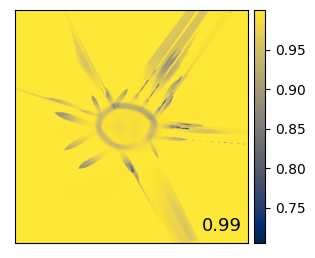

In [193]:

percent_list = np.sum(eigen_list[:, :2], axis=1)
print(percent_list.shape)
percent_list = percent_list.reshape(blob_box.shape)
# flip the
blob_box = np.flip(blob_box, axis=0)
perc_blob = plt.imshow(percent_list, cmap='cividis', alpha=1,)
plt.colorbar(perc_blob, pad=0.02)
plt.xticks([])
plt.yticks([])
mean_perc = np.mean(percent_list)
plt.text(0.63, 0.12, f'{mean_perc:.2f}', fontsize=13, transform=plt.gcf().transFigure)

fig = plt.gcf()
fig.set_size_inches(3.3,2.68)

# set aspect ratio
# plt.gca().set_aspect('equal')

plt.tight_layout()

## force the aspect ratio
# plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('./figures/blob30_local_perc.pdf', bbox_inches='tight', pad_inches=0.01)
plt.savefig('../paper/PAPER_intrinsic_dim/figures/blob30_local_perc.pdf', bbox_inches='tight', pad_inches=0.01)

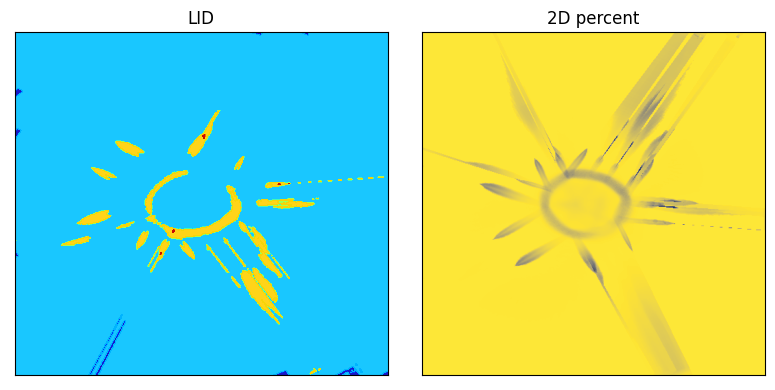

In [175]:
fig_blbo, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.contourf(blob_box, cmap='jet', alpha=0.9, )
ax1.set_title('LID')
ax1.set_xticks([])
ax1.set_yticks([])
# cbar
cbar = fig.colorbar(img, ax=ax)

ax2.imshow(percent_list, cmap='cividis', alpha=1,)
ax2.set_title('2D percent')
ax2.set_xticks([])
ax2.set_yticks([])
fig_blbo.tight_layout()
# plt.savefig('./figures/blob30_local.pdf', bbox_inches='tight', pad_inches=0.01)


## HAR

In [7]:
har = datasets_real['har']
har_X = har[0]
har_y = har[2]

clf_har = LogisticRegression(max_iter=1000, random_state=420)
DV_har = projectors['DeepView']

In [9]:
clf_har.fit(har_X, har_y)
DV_har.fit(har_X, har_y, clf=clf_har)

100%|██████████| 5000/5000 [17:56<00:00,  4.64it/s] 


updating matrices
(0,) (5000, 5000)
discr 0.2581593990325928
(0,) (5000, 5000)
fitting mapper
transforming
fitting inverse
done
fitting time:  1396.6036019325256


1396.6036019325256

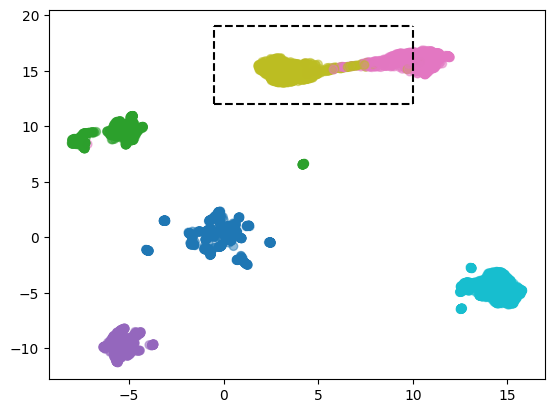

In [10]:
har_2D = DV_har.P.embedding_
cmap = 'tab10'
# blob_c = cm.tab10(blob30_y/9)

plt.scatter(har_2D[:,0], har_2D[:,1], marker='o', c=har_y, cmap=cmap, alpha=0.5)

x_min, x_max = [-0.5, 10]
y_min, y_max = [12, 19]

# plot the rectangular
plt.plot([x_min, x_min], [y_min, y_max], 'k--')
plt.plot([x_max, x_max], [y_min, y_max], 'k--')
plt.plot([x_min, x_max], [y_min, y_min], 'k--')
plt.plot([x_min, x_max], [y_max, y_max], 'k--')

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 500))
XY_har = np.c_[xx.ravel(), yy.ravel()]

In [62]:


print(XY_har.shape)

har_inv = DV_har.inverse_transform(XY_har)

print('computing LID')
har_eigen_list, har_lid_lsit = get_eigen_general(har_inv)
# save the data

np.save('.\local\har_eigen_id.npy', har_inv)

(500000, 2)
computing LID


100%|██████████| 500000/500000 [4:55:09<00:00, 28.23it/s]   


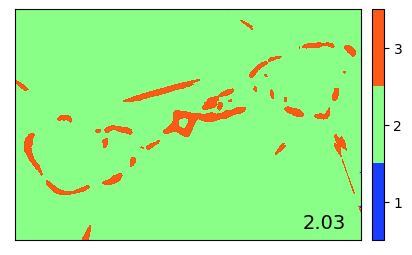

In [186]:
har_eigen_list, har_lid_lsit = np.load('.\local\har_eigen_id.npy', allow_pickle=True)

har_box = har_lid_lsit.reshape((1000,500))
# flip the

har_box_img = np.flip(har_box, axis=0)

# img = plt.imshow(har_box, cmap='jet', alpha=0.9, extent=[x_min, x_max, y_min, y_max])
# har_box_mean = np.mean(har_box)
# plt.text(0.5, 12, f'LID={har_box_mean:.2f}', fontsize=15, )
# # cbar
# cbar = plt.colorbar(img)
cnt = plt.contourf(xx, yy, har_box, cmap='jet', alpha=0.9, levels=[0.5,1.5,2.5,3.5], )
# h_img = plt.imshow(har_box, cmap='jet', alpha=0.9, extent=[x_min, x_max, y_min, y_max] )
har_box_mean = np.mean(har_box)
# set text , dont use absolute location
plt.text(0.83, 0.05, f'{har_box_mean:.2f}', fontsize=14, transform=plt.gca().transAxes )

# cbar
cbar = plt.colorbar(cnt, ticks=[1,2,3,4], pad = 0.02)
# set the aspect ratio to be corresponding to the xlim and ylim
# set figure size
fig = plt.gcf()
fig.set_size_inches(7,3)

# set the absolute values of x and y to be the same
plt.gca().set_aspect('equal', adjustable='box')

# not show the ticks
plt.xticks([])
plt.yticks([])

plt.show()
# fig
# save the figure
fig.savefig('./figures/har_lid_loc.pdf', bbox_inches='tight')
fig.savefig('../paper/PAPER_intrinsic_dim//figures/har_lid_loc.pdf', bbox_inches='tight')

(500000,)


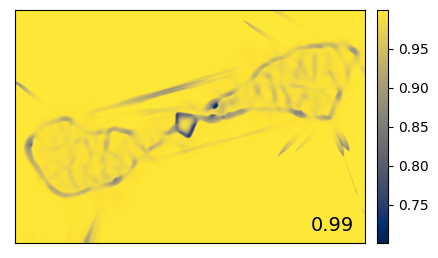

In [182]:

percent_list_har = np.sum(har_eigen_list[:, :2], axis=1)
print(percent_list_har.shape)
percent_list_har = percent_list_har.reshape(har_box.shape)
# flip the
percent_list_har = np.flip(percent_list_har, axis=0)
perc_har = plt.imshow(percent_list_har, cmap='cividis', alpha=1, extent=[x_min, x_max, y_min, y_max])
plt.colorbar(perc_har, pad=0.02)
plt.xticks([])
plt.yticks([])
mean_perc = np.mean(percent_list_har)
plt.text(0.73, 0.12, f'{mean_perc:.2f}', fontsize=14, transform=plt.gcf().transFigure)

fig = plt.gcf()
fig.set_size_inches(6.4,2.68)

# set aspect ratio
plt.gca().set_aspect('equal')

plt.tight_layout()

# save the figure
fig.savefig('./figures/har_perc_loc.pdf', bbox_inches='tight')
fig.savefig('../paper/PAPER_intrinsic_dim//figures/har_perc_loc.pdf', bbox_inches='tight')
